# 18. 딥러닝 레이어의 이해(1) Linear, Convolution

## 학습 목표

* 레이어의 개념을 이해한다.
* 딥러닝 모델 속 각 레이어(Linear, Convolution)의 동작 방식을 이해한다.
* 데이터의 특성을 고려한 레이어를 설계하고, 이를 Tensorflow로 정의하는 법을 배운다.

* 인공 신경망 네트워크(Artificial Neural Network(ANN), 이하 신경망)
* 딥러닝 : y = Wx + b 에서 최적의 W(weight)와 b(bias)를 찾는 과정!
* 올바른 Weight를 정의하는 과정
* 이번 노드는 Linear, Convolution layer를 다음 노드는 Embedding, Recurrent layer

## 데이터의 형태

* 데이터의 형태의 변화를 쫓는 것 

### 표

기업 A의 Data

In [1]:
import pandas as pd

company1 = {'이름' : ['홍길동', '김영희', '제임스'], '나이' : [28,27,32], '성별' : ['남','여','남'],
            '관심분야' : ['자연어 처리','영상 처리','IOS 개발'],
            '홈페이지' : ['gildong.modulab.com','yhkim.modulab.com','james.modulab.com'],
            '이메일' : ['gdh@modulab.com', 'yooong@modulab.com', 'jms152@modulab.com']}
df_c1 = pd.DataFrame(company1)
df_c1

이름  나이 성별    관심분야                 홈페이지                 이메일
0  홍길동  28  남  자연어 처리  gildong.modulab.com     gdh@modulab.com
1  김영희  27  여   영상 처리    yhkim.modulab.com  yooong@modulab.com
2  제임스  32  남  IOS 개발    james.modulab.com  jms152@modulab.com

기업 B의 Data

In [2]:
company2 = {'이름' : ['박길동', '최영희', '김임스'], '나이' : [27,26,33], '성별' : ['남','여','남'],
            '관심분야' : ['서버관리','웹 개발','디자이너'],
            '홈페이지' : ['gdpark@modulab.com','yhch.modulab.com','kimes.modulab.com'],
            '이메일' : ['gdp02@modulab.com', 'yhch@modulab.com', 'kimes77@modulab.com']}
df_c2 = pd.DataFrame(company2)
df_c2

이름  나이 성별  관심분야                홈페이지                  이메일
0  박길동  27  남  서버관리  gdpark@modulab.com    gdp02@modulab.com
1  최영희  26  여  웹 개발    yhch.modulab.com     yhch@modulab.com
2  김임스  33  남  디자이너   kimes.modulab.com  kimes77@modulab.com

기업 A의 데이터에 B의 데이터가 추가된다면  
ignore_index를 쓰지 않으면 기존의 index가 추가된다.

In [3]:
df_c = pd.concat([df_c1,df_c2], ignore_index= True)
df_c.loc[:2,'기업'] = '기업 A'
df_c.loc[3:,'기업'] = '기업 B'
df_c.set_index('기업')


이름  나이 성별    관심분야                 홈페이지                  이메일
기업                                                                
기업 A  홍길동  28  남  자연어 처리  gildong.modulab.com      gdh@modulab.com
기업 A  김영희  27  여   영상 처리    yhkim.modulab.com   yooong@modulab.com
기업 A  제임스  32  남  IOS 개발    james.modulab.com   jms152@modulab.com
기업 B  박길동  27  남    서버관리   gdpark@modulab.com    gdp02@modulab.com
기업 B  최영희  26  여    웹 개발     yhch.modulab.com     yhch@modulab.com
기업 B  김임스  33  남    디자이너    kimes.modulab.com  kimes77@modulab.com

pandas의 multiindex를 사용하면 index를 합칠수 있습니다.

### 이미지

* 이미지는 보통 채널을 가집니다.(ex RGB)

(6000, 4200, 3)


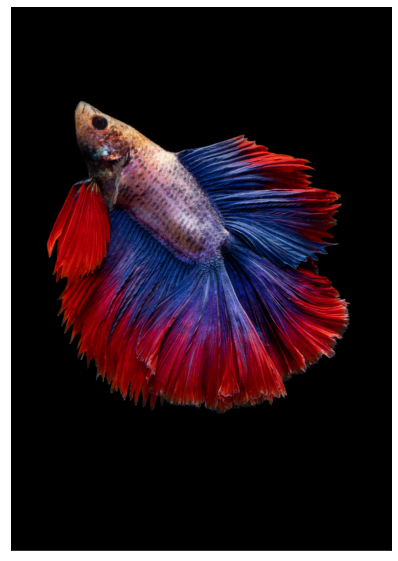

In [4]:
import cv2
import matplotlib.image as img
import matplotlib.pyplot as plt

fish_path = '/home/aiffel/Code/AiffelPractice/Fundamental18/fish.jpg'
fish = cv2.imread(fish_path)
print(fish.shape)
fish = cv2.cvtColor(fish, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (7,10))
plt.xticks([]), plt.yticks([])
plt.imshow(fish)
plt.show()

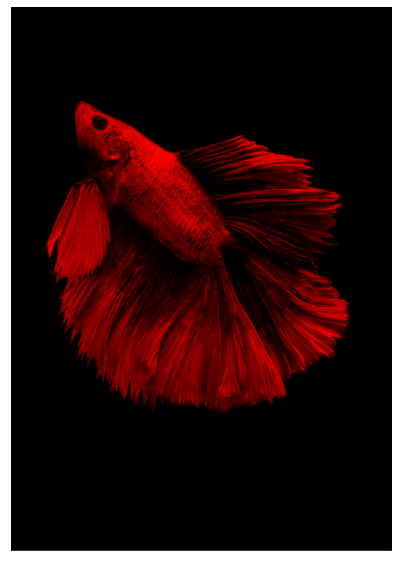

In [5]:
fish_R = fish.copy()
fish_R[:,:,1] = 0
fish_R[:,:,2] = 0
plt.figure(figsize = (7,10))
plt.xticks([]), plt.yticks([])
plt.imshow(fish_R)
plt.show()

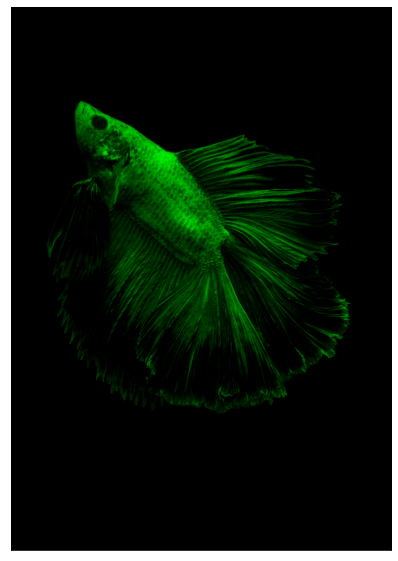

In [6]:
fish_G = fish.copy()
fish_G[:,:,0] = 0
fish_G[:,:,2] = 0
plt.figure(figsize = (7,10))
plt.xticks([]), plt.yticks([])
plt.imshow(fish_G)
plt.show()

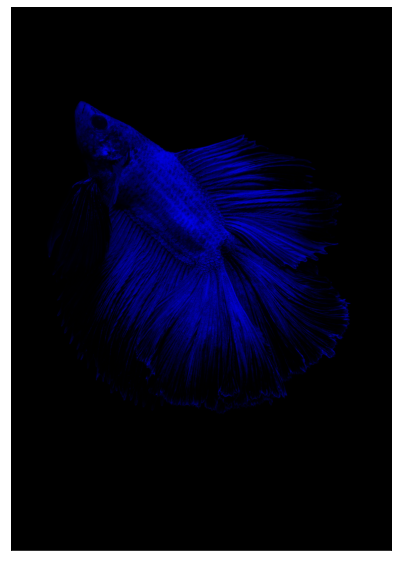

In [7]:
fish_B = fish.copy()
fish_B[:,:,0] = 0
fish_B[:,:,1] = 0
plt.figure(figsize = (7,10))
plt.xticks([]), plt.yticks([])
plt.imshow(fish_B)
plt.show()

## 레이어

* 레이어 : 여러 개의 논리적인 개체가 층을 이루어서 하나의 물체를 구성하는 경우, 이러한 각각의 객체
* 신경망의 W = 레이어의 W

## Linear 레이어

* Linear layer : Linear transformation을 통해 특정 차원으로 변환하는 기능
* 저차원으로 변환 : 데이터를 집약시킴
  * 2차원을 1차원으로 변환 : (2,1)
  * 4차원을 1차원으로 변환 : (4,1)
  * 이런 각각의 행렬을 W
* 고차원으로 변환 : 데이터를 풍부하게 함

#### Weight 고려

In [8]:
import tensorflow as tf

batch_size = 64
boxes = tf.zeros((batch_size, 4, 2))     # Tensorflow는 Batch를 기반으로 동작하기에,
                                         # 우리는 사각형 2개 세트를 batch_size개만큼
                                         # 만든 후 처리를 하게 됩니다.
print("1단계 연산 준비:", boxes.shape)

first_linear = tf.keras.layers.Dense(units=1, use_bias=False) 
# units은 출력 차원 수를 의미합니다.
# Weight 행렬 속 실수를 인간의 뇌 속 하나의 뉴런 '유닛' 취급을 하는 거죠!

first_out = first_linear(boxes)
first_out = tf.squeeze(first_out, axis=-1) # (4, 1)을 (4,)로 변환해줍니다.
                                           # (불필요한 차원 축소)

print("1단계 연산 결과:", first_out.shape)
print("1단계 Linear Layer의 type:", type(first_linear))
print("1단계 Linear Layer의 Weight 형태:", first_linear.weights[0].shape)

print("\n2단계 연산 준비:", first_out.shape)

second_linear = tf.keras.layers.Dense(units=1, use_bias=False)
second_out = second_linear(first_out)
second_out = tf.squeeze(second_out, axis=-1)

print("2단계 연산 결과:", second_out.shape)
print("2단계 Linear Layer의 Weight 형태:", second_linear.weights[0].shape)

2022-08-04 21:00:09.686072: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/aiffel/.local/lib/python3.10/site-packages/cv2/../../lib64:
2022-08-04 21:00:09.686092: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


1단계 연산 준비: (64, 4, 2)
1단계 연산 결과: (64, 4)
1단계 Linear Layer의 type: <class 'keras.layers.core.dense.Dense'>
1단계 Linear Layer의 Weight 형태: (2, 1)

2단계 연산 준비: (64, 4)
2단계 연산 결과: (64,)
2단계 Linear Layer의 Weight 형태: (4, 1)


2022-08-04 21:00:12.664220: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-04 21:00:12.664382: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/aiffel/.local/lib/python3.10/site-packages/cv2/../../lib64:
2022-08-04 21:00:12.664418: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/aiffel/.local/lib/python3.10/site-packages/cv2/../../lib64:
2022-08-04 21:00:12.664450: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: lib

* Dense : Just your regular densely-connected NN layer.
* [Tensorflow Dense doc.](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)
* Args:
  - units : Positive integer, dimensionality of the output space. (출력 공간의 차원)
  - activation : Activation function to use. If you don't specify anything, no activation is applied (ie. "linear" activation: a(x) = x).  
    (사용할 활성화 함수 설정. 아무것도 정해놓지 않으면 활성화 함수를 적용하지 않는다.)
  - use_bias : Boolean, whether the layer uses a bias vector. (편항 벡터를 사용할지 안할지 boolean)
  - kernel_initializer : Initializer for the kernel weights matrix. (커널 가중치 행렬 초기화용)
  - bias_initializer : Initializer for the bias vector. (편항 벡터 초기화용)
  - kernel_regularizer : Regularizer function applied to the kernel weights matrix. (커널 가중치 행렬에 적용할 정규화 함수)
  - bias_regularizer : Regularizer function applied to the bias vector. (편항 벡터에 적용할 정규화 함수)
  - activity_regularizer : Regularizer function applied to the output of the layer (its "activation").  
    (출력층 layer에 적용할 정규화 함수(활성화))
  - kernel_constraint : Constraint function applied to the kernel weights matrix. (커널 가중치 행렬에 적용할 제약 함수, Optimization)
    (max_norm, min_norm 같이 W의 제한 범위를 설정한다는 개념)
  - bias_constraint	 : Constraint function applied to the bias vector. (편항 벡터에 적용할 제약 함수, Optimization)

In [9]:
import numpy as np

batch_size = 64
boxes = tf.zeros((batch_size, 4, 2))

print("1단계 연산 준비:", boxes.shape)

########
# Step 1: (4,2)차원인 boxes를 (4,3)으로 확장시키는 Linear Layer를 활용하세요.
# Enter Your Source
first_linear = tf.keras.layers.Dense(units=3, use_bias=False)
first_out = first_linear(boxes)
########

print("1단계 연산 결과:", first_out.shape)
print("1단계 Linear Layer의 Weight 형태:", first_linear.weights[0].shape)

print("\n2단계 연산 준비:", first_out.shape)

# Dense = Linear
second_linear = tf.keras.layers.Dense(units=1, use_bias=False)
second_out = second_linear(first_out)
second_out = tf.squeeze(second_out, axis=-1)

print("2단계 연산 결과:", second_out.shape)
print("2단계 Linear Layer의 Weight 형태:", second_linear.weights[0].shape)

print("\n3단계 연산 준비:", second_out.shape)

########
# Step 2: 4차원인 second_out을 하나의 실수으로 집약시키는 Linear Layer를 활용하세요.
# Enter Your Source
third_linear = tf.keras.layers.Dense(units=1, use_bias=False)
third_out = third_linear(second_out)
third_out = tf.squeeze(third_out, axis=-1)
########

print("3단계 연산 결과:", third_out.shape)
print("3단계 Linear Layer의 Weight 형태:", third_linear.weights[0].shape)

########
# Step 3: 모든 params를 더하여 total_parmams를 구하세요.
# Enter Your Source
########
sum_1 = sum(first_linear.weights[0].shape)
sum_2 = sum(second_linear.weights[0].shape)
sum_3 = sum(third_linear.weights[0].shape)

total_params = sum_1 + sum_2 + sum_3

print("총 Parameters:", total_params)

1단계 연산 준비: (64, 4, 2)
1단계 연산 결과: (64, 4, 3)
1단계 Linear Layer의 Weight 형태: (2, 3)

2단계 연산 준비: (64, 4, 3)
2단계 연산 결과: (64, 4)
2단계 Linear Layer의 Weight 형태: (3, 1)

3단계 연산 준비: (64, 4)
3단계 연산 결과: (64,)
3단계 Linear Layer의 Weight 형태: (4, 1)
총 Parameters: 14


In [10]:
print('first_linear.count_params() =', first_linear.count_params())
print('second_linear.count_params() =', second_linear.count_params())
print('third_linear.count_params() = ', third_linear.count_params())

first_linear.count_params() = 6
second_linear.count_params() = 3
third_linear.count_params() =  4


In [11]:
print('\nfirst_linear.unit =',first_linear.units)
print('second_linear.unit =',second_linear.units)
print('third_linear.unit =',third_linear.units)

print('\nfirst_linear.weights =',first_linear.weights)
print('\nsecond_linear.weights =',second_linear.weights)
print('\nthird_linear.weights =',third_linear.weights)

print('\nfirst_linear.weights len =',len(first_linear.weights))
print('second_linear.weights len =',len(second_linear.weights))
print('third_linear.weights len =',len(third_linear.weights))

print('\nfirst_linear.weights[0] shape =',first_linear.weights[0].shape)
print('second_linear.weights[0] shape =',second_linear.weights[0].shape)
print('third_linear.weights[0] shape =',third_linear.weights[0].shape)

print('\nfirst_linear.weights type =',type(first_linear))



first_linear.unit = 3
second_linear.unit = 1
third_linear.unit = 1

first_linear.weights = [<tf.Variable 'dense_2/kernel:0' shape=(2, 3) dtype=float32, numpy=
array([[ 0.07100737,  1.062093  , -0.45444697],
       [ 0.48449326, -1.036893  ,  1.0951192 ]], dtype=float32)>]

second_linear.weights = [<tf.Variable 'dense_3/kernel:0' shape=(3, 1) dtype=float32, numpy=
array([[-0.21234202],
       [ 0.80884564],
       [ 0.26582456]], dtype=float32)>]

third_linear.weights = [<tf.Variable 'dense_4/kernel:0' shape=(4, 1) dtype=float32, numpy=
array([[-0.2177375 ],
       [ 0.5122956 ],
       [-0.2958057 ],
       [-0.62188464]], dtype=float32)>]

first_linear.weights len = 1
second_linear.weights len = 1
third_linear.weights len = 1

first_linear.weights[0] shape = (2, 3)
second_linear.weights[0] shape = (3, 1)
third_linear.weights[0] shape = (4, 1)

first_linear.weights type = <class 'keras.layers.core.dense.Dense'>


* dense.weights 는 크기가 1인 list 형태

* 파라미터가 많다고 좋은건 아니다. - Overfitting 야기
* 훈련 : 가장 적합한 Weight를 찾아가는 과정

#### bias 고려

* biast(편항) : 원점을 평행 이동
* y = Wx + b 에서 b
* Dense class 에서 use_bias 사용

## Convolution 레이어

* 너무 큰 값을 (n, )로 하면 비효율적이기 때문에 고안된 레이어
* 필터와 이미지의 겹치는 부분을 계산해서 새로운 이미지로 만듬

### [OpenCV kernel image processing](https://towardsdatascience.com/basics-of-kernels-and-convolutions-with-opencv-c15311ab8f55)

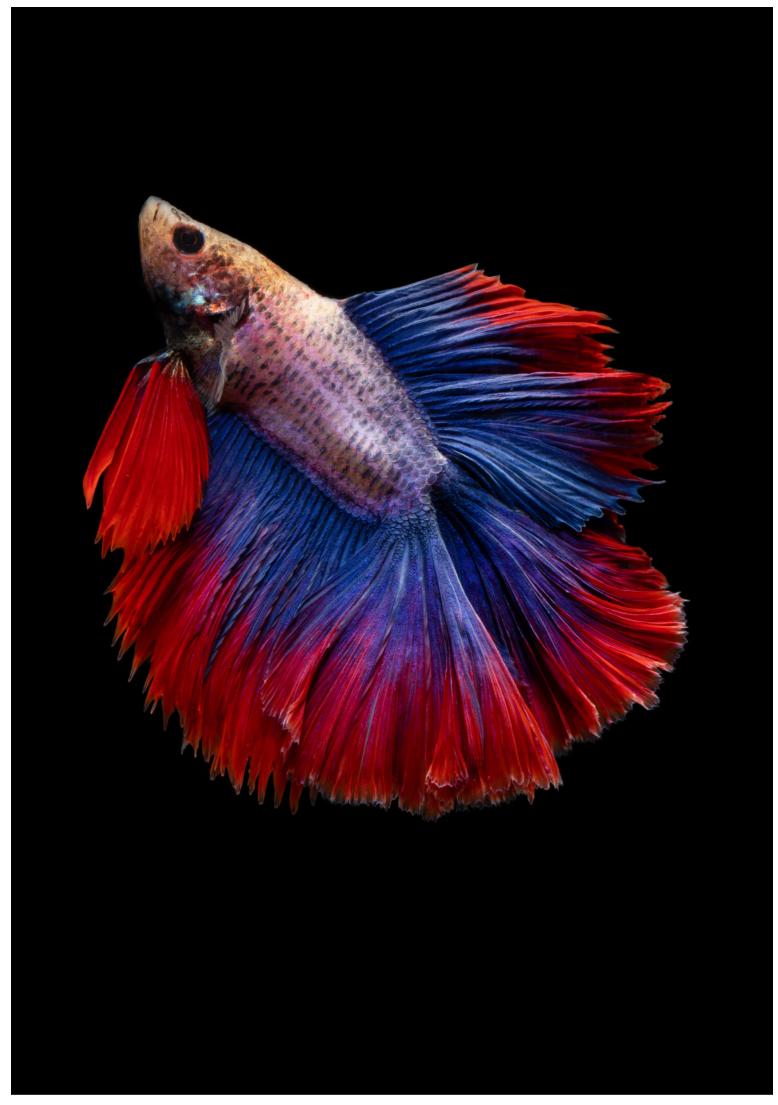

In [12]:
# 원본
fish_path = '/home/aiffel/Code/AiffelPractice/Fundamental18/fish.jpg'
fish = cv2.imread(fish_path)
fish_cv = cv2.cvtColor(fish, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (14,20))
plt.xticks([]), plt.yticks([])
plt.imshow(fish_cv)
plt.show()

흐리게하는 커널을 만들어봅니다.

In [13]:
blur_kernel = np.ones((3, 3), np.float32) / 9
blur_kernel

array([[0.11111111, 0.11111111, 0.11111111],
       [0.11111111, 0.11111111, 0.11111111],
       [0.11111111, 0.11111111, 0.11111111]], dtype=float32)

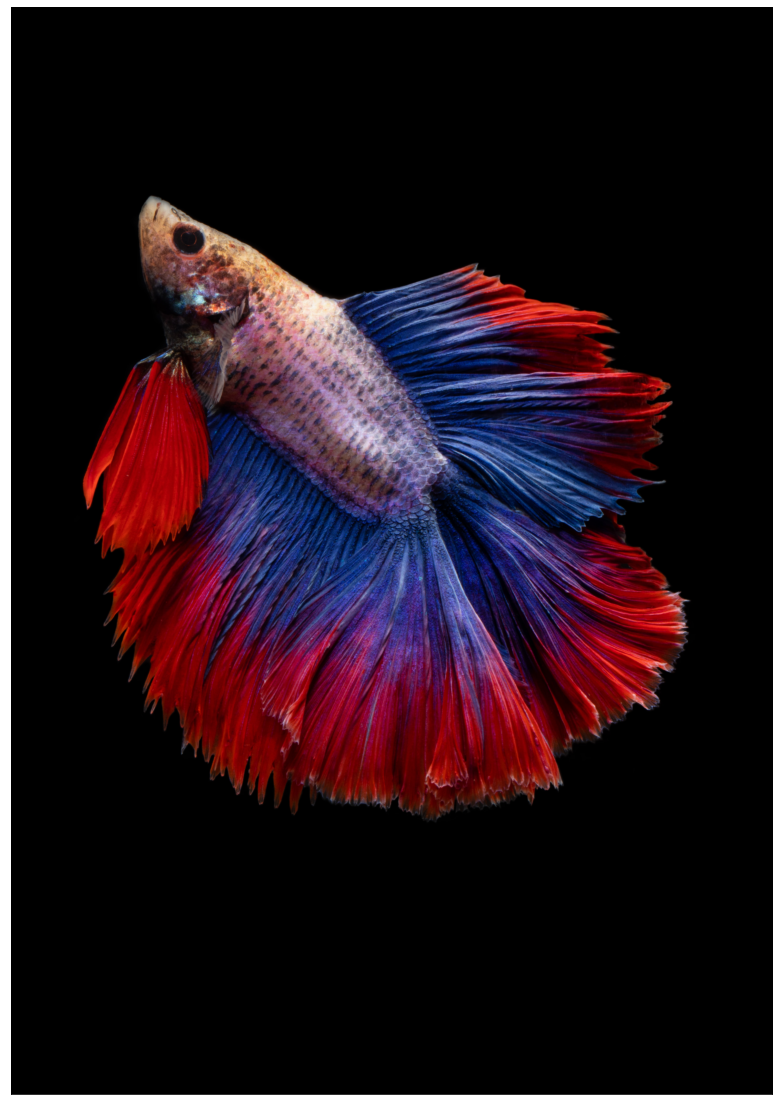

In [14]:
fish_blur = cv2.cvtColor(fish, cv2.COLOR_BGR2RGB)
fish_blur = cv2.filter2D(fish_blur, -1, blur_kernel)
plt.figure(figsize = (14,20))
plt.xticks([]), plt.yticks([])
plt.imshow(fish_blur)
plt.show()

이미지 자체가 워낙커서 흐리게 해도 큰 차이를 못느끼네요.  
sharpen kernel을 만들어보겠습니다.

In [15]:
sharpen_kernel = np.array([[0, -1, 0],
                           [-1, 5, -1],
                           [0, -1, 0]])

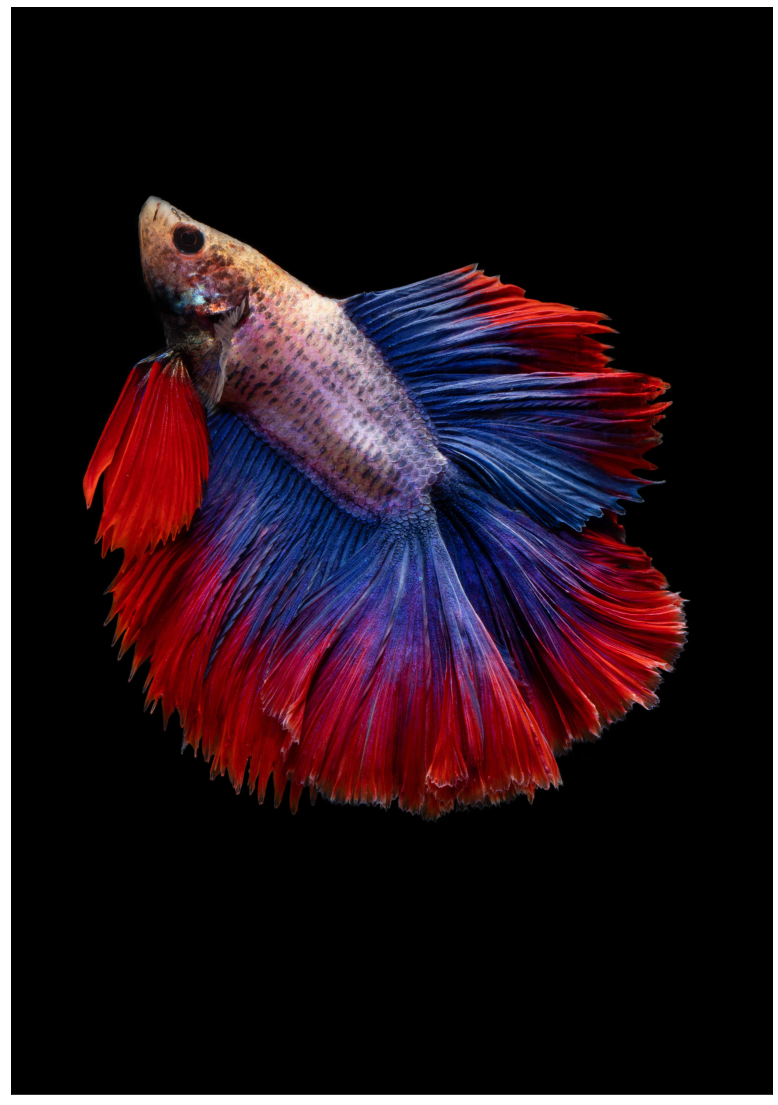

In [16]:
fish_sharpen = cv2.cvtColor(fish, cv2.COLOR_BGR2RGB)
fish_sharpen = cv2.filter2D(fish_sharpen, -1, sharpen_kernel)
plt.figure(figsize = (14,20))
plt.xticks([]), plt.yticks([])
plt.imshow(fish_sharpen)
plt.show()

역시 너무 커서 sharpen도 큰 차이를 못 느끼겠습니다.  
이미지의 특정 부분을 잘라서 확인해봅시다.

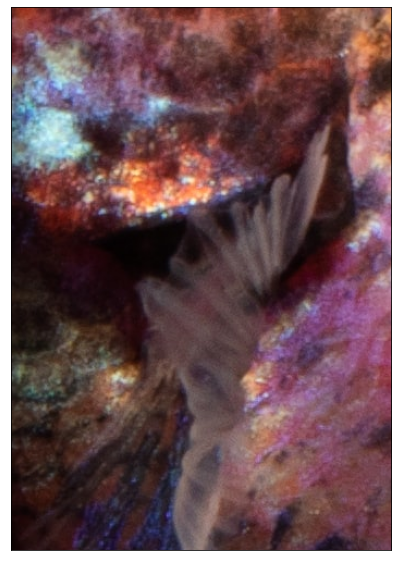

In [17]:
fish = cv2.imread(fish_path)
cropped_fish = fish[1500: 2000, 1000:1350]
cropped_fish = cv2.cvtColor(cropped_fish, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (7,10))
plt.xticks([]), plt.yticks([])
plt.imshow(cropped_fish)
plt.show()

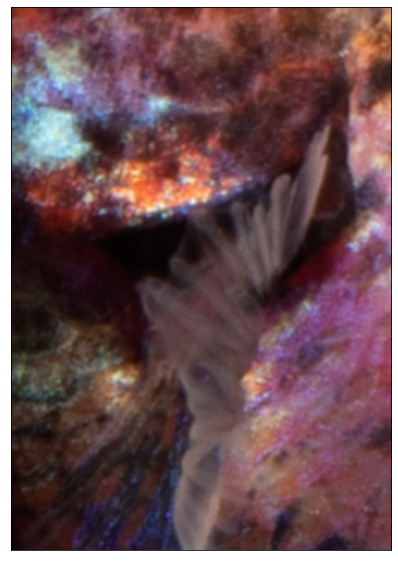

In [18]:
cropped_fish_blur = cv2.filter2D(cropped_fish, -1, blur_kernel)
plt.figure(figsize = (7,10))
plt.xticks([]), plt.yticks([])
plt.imshow(cropped_fish_blur)
plt.show()

약간 흐리게 되었습니다.  
sharpen도 해보겠습니다.

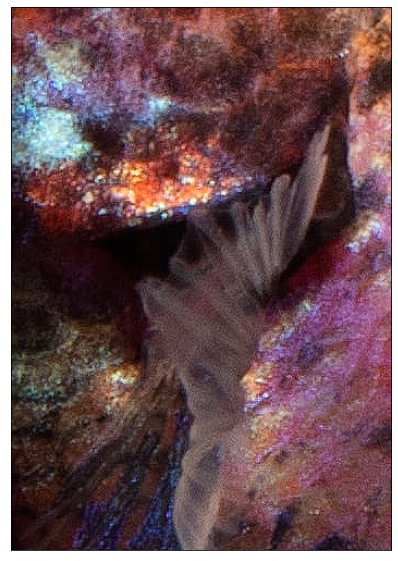

In [19]:
cropped_fish_sharpen = cv2.filter2D(cropped_fish, -1, sharpen_kernel)
plt.figure(figsize = (7,10))
plt.xticks([]), plt.yticks([])
plt.imshow(cropped_fish_sharpen)
plt.show()

확실히 선이 더 깊어졌습니다.

### 예시코드

* stride: filter(kernel)가 이미지에서 이동하면서 값을 바꿔주는데 이때 한번의 이동거리
* 모서리의 픽셀도 내곽 픽셀처럼 적용하기 위해 padding을 사용
* 위의 filter를 적용해 나온 값으로 feature를 뽑아내는 것
* 뽑아낸 feature들로 학습하는게 더 효율적 그냥 넣는 것 보다

In [20]:
import tensorflow as tf

batch_size = 64
pic = tf.zeros((batch_size, 1920, 1080, 3))

print("입력 이미지 데이터:", pic.shape)
conv_layer = tf.keras.layers.Conv2D(filters=16,
                                    kernel_size=(5, 5),
                                    strides=5,
                                    use_bias=False)
conv_out = conv_layer(pic)

print("\nConvolution 결과:", conv_out.shape)
print("Convolution Layer의 Parameter 수:", conv_layer.count_params())

flatten_out = tf.keras.layers.Flatten()(conv_out)
print("\n1차원으로 펼친 데이터:", flatten_out.shape)

linear_layer = tf.keras.layers.Dense(units=1, use_bias=False)
linear_out = linear_layer(flatten_out)

print("\nLinear 결과:", linear_out.shape)
print("Linear Layer의 Parameter 수:", linear_layer.count_params())

2022-08-04 21:00:20.887740: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1592524800 exceeds 10% of free system memory.


입력 이미지 데이터: (64, 1920, 1080, 3)

Convolution 결과: (64, 384, 216, 16)
Convolution Layer의 Parameter 수: 1200

1차원으로 펼친 데이터: (64, 1327104)

Linear 결과: (64, 1)
Linear Layer의 Parameter 수: 1327104


## Pooling 레이어

* Convolution 레이어를 통해 Linear 보다 훨씬 적은 파라미터로 효과적으로 중요한 이미지의 특징을 뽑아낼 수 있다.
* 하지만 필터의 크기가 작거나 커서 생기는 문제들이 있다.

* Receptive Field (수용 영역)
  - Neural Network의 출력부가 충분한 정보를 얻기 위해 커버하는 입력 데이터의 Receptive Field가 충분히 커서  
    안에 detect해야 할 object의 특성이 충분히 포함되어 있어야 정확한 detection이 가능  
  - Convolution, stride, pooling을 거쳤다고 볼 때 한 뉴런이 담당하는 원본 이미지의 크기
  - 최종 크기에서 과정들을 거치기전의 원본 이미지의 크기

* Max Pooling layer
  - 증가된 파라미터 사이즈 = 0
  - 비슷한 feature들을 불러와서 오버피팅 방지
  - 분류기의 성능 증진
  - 파라미터 사이즈 미증가로 인한 오버피팅, 연산량 증가 방지

## Deconvolution 레이어

### 단순 설명

* Deconvolution : Convolution Layer 를 통해 너무 많은 데이터가 손실되었다고 생각되는 경우  
Convolution 를 역재생해서 원본 이미지와 최대한 유사한 정보를 복원해내는 Auto Encoder


### MNIST Auto Encoder

In [21]:
import numpy as np
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import json
import matplotlib.pyplot as plt #for plotting

# MNIST 데이터 로딩
(x_train, _), (x_test, _) = mnist.load_data()    # y_train, y_test는 사용하지 않습니다.

print(x_train.shape)
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)
print(x_train.shape)

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

(60000, 28, 28)
(60000, 28, 28, 1)


x_test, y_test는 사용하지 않는다. - AutoEncoder는 train 본인이 target이기 때문  
axis=3, 3 axis에 차원을 하나 추가 : (60000, 28, 28) -> (60000, 28, 28, 1)  
/255 : Regularization

In [22]:
# AutoEncoder 모델 구성 - Input 부분
input_shape = x_train.shape[1:]
input_img = Input(shape=input_shape)

# AutoEncoder 모델 구성 - Encoder 부분
encode_conv_layer_1 = Conv2D(16, (3, 3), activation='relu', padding='same')
encode_pool_layer_1 = MaxPooling2D((2, 2), padding='same')
encode_conv_layer_2 = Conv2D(8, (3, 3), activation='relu', padding='same')
encode_pool_layer_2 = MaxPooling2D((2, 2), padding='same')
encode_conv_layer_3 = Conv2D(4, (3, 3), activation='relu', padding='same')
encode_pool_layer_3 = MaxPooling2D((2, 2), padding='same')

encoded = encode_conv_layer_1(input_img)
encoded = encode_pool_layer_1(encoded)
encoded = encode_conv_layer_2(encoded)
encoded = encode_pool_layer_2(encoded)
encoded = encode_conv_layer_3(encoded)
encoded = encode_pool_layer_3(encoded)

# AutoEncoder 모델 구성 - Decoder 부분
decode_conv_layer_1 = Conv2D(4, (3, 3), activation='relu', padding='same')
decode_upsample_layer_1 = UpSampling2D((2, 2))
decode_conv_layer_2 = Conv2D(8, (3, 3), activation='relu', padding='same')
decode_upsample_layer_2 = UpSampling2D((2, 2))
decode_conv_layer_3 = Conv2D(16, (3, 3), activation='relu')
decode_upsample_layer_3 = UpSampling2D((2, 2))
decode_conv_layer_4 = Conv2D(1, (3, 3), activation='sigmoid', padding='same')

decoded = decode_conv_layer_1(encoded)   # Decoder는 Encoder의 출력을 입력으로 받습니다.
decoded = decode_upsample_layer_1(decoded)
decoded = decode_conv_layer_2(decoded)
decoded = decode_upsample_layer_2(decoded)
decoded = decode_conv_layer_3(decoded)
decoded = decode_upsample_layer_3(decoded)
decoded = decode_conv_layer_4(decoded)

In [23]:
# AutoEncoder 모델 정의
autoencoder = Model(input_img, decoded)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 4)           292   

In [24]:
print(input_shape)
print(input_img)

(28, 28, 1)
KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


* input_shape는 (60000, 28, 28, 1) 에서 :1 이니 (28,28,1) 이다.
* input_img = from tensorflow.keras.layers import Input 로 선언됨
* Conv2D는 Shape를 변화시키지 않는다.
* 그래서 Shape는 Maxpooling을 3번 거쳐서 (4,4)가 된다.
* 다음은 Decoder Layer를 보겠습니다.

In [25]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
235/235 [==============================] - 30s 127ms/step - loss: 0.6886 - val_loss: 0.6879
Epoch 2/10
235/235 [==============================] - 30s 126ms/step - loss: 0.6869 - val_loss: 0.6860
Epoch 3/10
235/235 [==============================] - 30s 126ms/step - loss: 0.6848 - val_loss: 0.6836
Epoch 4/10
235/235 [==============================] - 29s 125ms/step - loss: 0.6820 - val_loss: 0.6806
Epoch 5/10
235/235 [==============================] - 29s 123ms/step - loss: 0.6786 - val_loss: 0.6766
Epoch 6/10
235/235 [==============================] - 29s 122ms/step - loss: 0.6740 - val_loss: 0.6715
Epoch 7/10
235/235 [==============================] - 29s 123ms/step - loss: 0.6679 - val_loss: 0.6644
Epoch 8/10
235/235 [==============================] - 29s 122ms/step - loss: 0.6594 - val_loss: 0.6543
Epoch 9/10
235/235 [==============================] - 29s 122ms/step - loss: 0.6469 - val_loss: 0.6391
Epoch 10/10
235/235 [==============================] - 28s 118ms/step - l

AutoEncoder를 훈련시켜보겠습니다.  
y_train 대신 x_train, y_test 대신 x_test를 넣어야합니다.

1/1 [==============================] - 0s 63ms/step


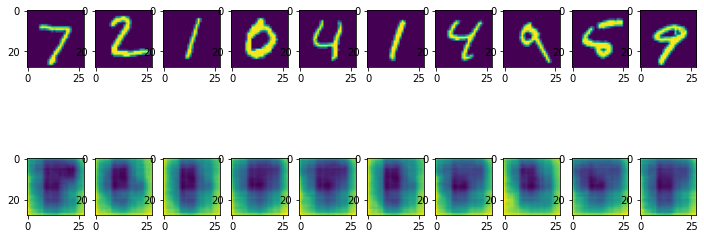

In [26]:
x_test_10 = x_test[:10]       # 테스트 데이터셋에서 10개만 골라서
x_test_hat = autoencoder.predict(x_test_10)    # AutoEncoder 모델의 이미지 복원생성
x_test_imgs = x_test_10.reshape(-1, 28, 28)
x_test_hat_imgs = x_test_hat.reshape(-1, 28, 28)

plt.figure(figsize=(12,5))  # 이미지 사이즈 지정
for i in range(10): 
    # 원본이미지 출력
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test_imgs[i])
    # 생성된 이미지 출력
    plt.subplot(2, 10, i+11)
    plt.imshow(x_test_hat_imgs[i])

생각보다 못 만들어 냅니다.

### Decoder Layers for Reconstruction

위의 Model 코드에서 Decoder 부분의 Convolution Layer는 Encoder에서 사용한 것과 동일한 Layer 였습니다.  
즉 단지 크기만 다시 늘려주는 것 입니다. 어쨋든 정보의 크기는 커졌습니다.

Convolution의 수학적 역연산으로서의 Deconvolution과는 다르다.  
결국 AutoEncoder 가 얼마나 정보를 잘 압축하는지에 따라 Decoder가 뽑아낼 수 있는 퀄리티가 달라진다.

[링크 참조](https://analysisbugs.tistory.com/104#recentEntries)
* Max Pooling Layer : Downsampling
* Upsampling : Max Pooling과 반대
* Upsampling의 3가지 방법
  1. Nearest Neighbor : 복원해야 할 값을 가까운 값으로 복제한다.
  2. Bed of Nails : 복원해야 할 값을 0으로 처리한다.
  3. Max Unpooling : Max Pooling 때 버린 값을 실은 따로 기억해 두었다가 그 값으로 복원한다.

### Transposed Convolution

In [27]:
from tensorflow.keras.layers import Conv2DTranspose

# Conv2DTranspose를 활용한  AutoEncoder 모델
# AutoEncoder 모델 구성 - Input 부분
input_shape = x_train.shape[1:]
input_img = Input(shape=input_shape)

# AutoEncoder 모델 구성 - Encoder 부분
encode_conv_layer_1 = Conv2D(16, (3, 3), activation='relu')
encode_pool_layer_1 = MaxPooling2D((2, 2))
encode_conv_layer_2 = Conv2D(8, (3, 3), activation='relu')
encode_pool_layer_2 = MaxPooling2D((2, 2))
encode_conv_layer_3 = Conv2D(4, (3, 3), activation='relu')

encoded = encode_conv_layer_1(input_img)
encoded = encode_pool_layer_1(encoded)
encoded = encode_conv_layer_2(encoded)
encoded = encode_pool_layer_2(encoded)
encoded = encode_conv_layer_3(encoded)

# AutoEncoder 모델 구성 - Decoder 부분  - 
decode_conv_layer_1 = Conv2DTranspose(4, (3, 3), activation='relu', padding='same')
decode_upsample_layer_1 = UpSampling2D((2, 2))
decode_conv_layer_2 = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')
decode_upsample_layer_2 = UpSampling2D((2, 2))
decode_conv_layer_3 = Conv2DTranspose(16, (3, 3), activation='relu')
decode_upsample_layer_3 = UpSampling2D((2, 2))
decode_conv_layer_4 = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')

decoded = decode_conv_layer_1(encoded)   # Decoder는 Encoder의 출력을 입력으로 받습니다.
decoded = decode_upsample_layer_1(decoded)
decoded = decode_conv_layer_2(decoded)
decoded = decode_upsample_layer_2(decoded)
decoded = decode_conv_layer_3(decoded)
decoded = decode_upsample_layer_3(decoded)
decoded = decode_conv_layer_4(decoded)

In [28]:
# AutoEncoder 모델 정의
autoencoder2 = Model(input_img, decoded)
autoencoder2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 13, 16)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 11, 11, 8)         1160      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 5, 5, 8)          0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 3, 3, 4)           292 

In [29]:
autoencoder2.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder2.fit(x_train, x_train, epochs=10, batch_size=256, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/10
235/235 [==============================] - 7s 30ms/step - loss: 0.6942 - val_loss: 0.6938
Epoch 2/10
235/235 [==============================] - 11s 49ms/step - loss: 0.6934 - val_loss: 0.6928
Epoch 3/10
235/235 [==============================] - 14s 60ms/step - loss: 0.6920 - val_loss: 0.6912
Epoch 4/10
235/235 [==============================] - 14s 61ms/step - loss: 0.6903 - val_loss: 0.6894
Epoch 5/10
235/235 [==============================] - 14s 61ms/step - loss: 0.6885 - val_loss: 0.6876
Epoch 6/10
235/235 [==============================] - 14s 61ms/step - loss: 0.6866 - val_loss: 0.6857
Epoch 7/10
235/235 [==============================] - 14s 61ms/step - loss: 0.6847 - val_loss: 0.6837
Epoch 8/10
235/235 [==============================] - 14s 60ms/step - loss: 0.6826 - val_loss: 0.6815
Epoch 9/10
235/235 [==============================] - 14s 61ms/step - loss: 0.6802 - val_loss: 0.6789
Epoch 10/10
235/235 [==============================] - 14s 60ms/step - loss: 0.6775

1/1 [==============================] - 0s 85ms/step


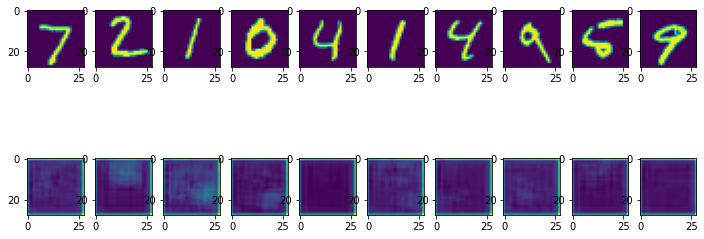

In [30]:
x_test_10 = x_test[:10]       # 테스트 데이터셋에서 10개만 골라서
x_test_hat = autoencoder2.predict(x_test_10)    # AutoEncoder 모델의 이미지 복원생성
x_test_imgs = x_test_10.reshape(-1, 28, 28)
x_test_hat_imgs = x_test_hat.reshape(-1, 28, 28)

plt.figure(figsize=(12,5))  # 이미지 사이즈 지정
for i in range(10): 
    # 원본이미지 출력
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test_imgs[i])
    # 생성된 이미지 출력
    plt.subplot(2, 10, i+11)
    plt.imshow(x_test_hat_imgs[i])